In [1]:
from chessnet.notebook_config import *
from chessnet.graphs import read_pickle, read_rewired_graph

In [2]:
graphs = {"OTB": read_pickle(Database.OTB), "Portal": read_pickle(Database.Portal)}

In [5]:
ran_graphs = {
    "OTB": read_rewired_graph(Database.OTB, nswap_ecount_times=0.1),
    "Portal": read_rewired_graph(Database.Portal, nswap_ecount_times=0.1)
}

In [6]:
comm_data = {
    "OTB": graphs["OTB"].community_multilevel(),
    "Portal": graphs["Portal"].community_multilevel(),
}

In [7]:
ran_comm_data = {
    "OTB": ran_graphs["OTB"].community_multilevel(),
    "Portal": ran_graphs["Portal"].community_multilevel(),
}

In [8]:
def get_community_data(g, communities, min_size: int = 1):
    data = []
    for comm in communities:
        Nc = len(comm)
        if Nc < min_size:
            continue
        comm_elos = [g.vs[index]["MeanElo"] for index in comm]
        row = [Nc, np.mean(comm_elos), np.std(comm_elos)]
        data.append(row)

    df = pd.DataFrame(
        data,
        columns=["Nc", "MeanElo", "StdElo"]
    ).sort_values(by="MeanElo", ascending=False).reset_index(drop=True)
    return df

In [9]:
def plot_elo_per_community(df, ax = None):
    if ax is None:
        _, ax = plt.subplots()
    X = df.index+1
    Y = df.MeanElo
    Yerr = df.StdElo
    Yfill_min = Y - Yerr
    Yfill_max = Y + Yerr
    ax.scatter(X, Y, s=10*np.log(df.Nc), color=f"C{i}")
    ax.fill_between(X, Yfill_min, Yfill_max, alpha=0.5, color=f"C{i}")
    ax.set_xticks([0, 10, 20, 30, 40])
    ax.set_xlim(0, 42)
    return ax

/tmp/ipykernel_125837/848309025.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


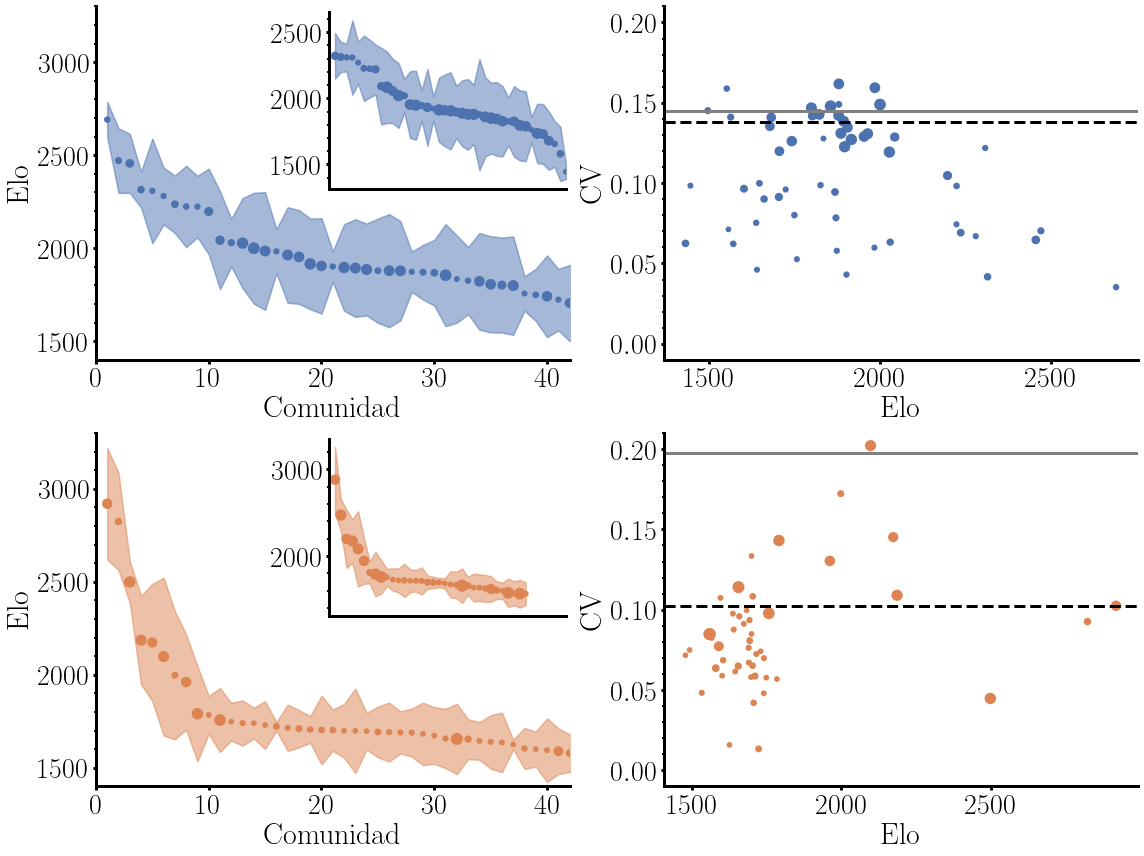

In [18]:
min_size = 6
ncols, nrows = 2, 2
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)
for i, (name, communities) in enumerate(comm_data.items()):
    g = graphs[name]
    ax = axes[i,0]
    ax.set_ylim(1400, 3300)
    ax.set_xlabel(r"$\mathrm{Comunidad}$")
    ax.set_ylabel(r"$\mathrm{Elo}$")
    df = get_community_data(g, communities, min_size=min_size)
    plot_elo_per_community(df, ax=ax)

    ax = axes[i,1]
    ax.set_xlabel(r"$\mathrm{Elo}$")
    ax.set_ylabel(r"$\mathrm{CV}$")
    CV_values = df.StdElo / df.MeanElo
    ax.scatter(df.MeanElo, df.StdElo / df.MeanElo, s=10*np.log(df.Nc), color=f"C{i}")
    ax.axhline(np.std(g.vs["MeanElo"]) / np.mean(g.vs["MeanElo"]), color="gray")
    ax.axhline(np.dot(df.Nc, CV_values) / df.Nc.sum(), linestyle="--", color="k")
    ax.set_ylim(-0.01, 0.21)

for i, (name, communities) in enumerate(ran_comm_data.items()):
    g = graphs[name]
    ax = axes[i,0]
    df = get_community_data(g, communities, min_size=min_size)

    bbox_to_anchor = (.52, .52, .5, .5)
    axins = inset_axes(
        ax, width="100%", height="100%",
        bbox_to_anchor=bbox_to_anchor,
        bbox_transform=ax.transAxes
    )
    plot_elo_per_community(df, ax=axins)
    axins.set_xlim(0, 41)
    axins.set_xticks([])
sns.despine()
plt.tight_layout()
plt.show()